# Binary Face Classification with PyTorch

## 0. Setup Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You need to have a the zipped folder `ml_exercise_therapanacea.zip` in your drive with this structure


```
TARGET_WORKING_DIR/   <-- This is the main project data folder in Google Drive
└── ml_exercise_therapanacea.zip        <-- ZIP file with training dataset
    └── label_train.txt
    └── train_img
    └── val_img
```




In [3]:
import os

TARGET_WORKING_DIR = "/content/drive/MyDrive/Deep/thera" # CHANGE THIS LINE

DRIVE_ZIP_FILENAME = 'ml_exercise_therapanacea.zip'
DRIVE_PATH_TO_ZIP = os.path.join(TARGET_WORKING_DIR, DRIVE_ZIP_FILENAME)

LABEL_FILENAME_IN_ZIP = "label_train.txt"
TRAIN_IMAGE_DIR_NAME_IN_ZIP = 'train_img'
VAL_IMAGE_DIR_NAME_IN_ZIP = 'val_img'

In [4]:
if os.path.isdir(TARGET_WORKING_DIR):
    os.chdir(TARGET_WORKING_DIR)
    print(f"Working directory changed to: {os.getcwd()}")
else:
    print(f"ERROR: Directory not found - {TARGET_WORKING_DIR}")

Working directory changed to: /content/drive/.shortcut-targets-by-id/1Kt4jHJGjoFxeM_o_eCFSprkfZbPHOaGU/Deep/thera


In [5]:
%load_ext autoreload
%autoreload 2

## 1. Configuration and Data Paths


It is faster to copy the zipped images and unzip it locally each time with collab. So that what we are going to do that

In [6]:
import shutil

# --- Local Colab Paths ---
LOCAL_DATA_ROOT = '/content/face_classification_data/'
LOCAL_ZIP_PATH = os.path.join(LOCAL_DATA_ROOT, DRIVE_ZIP_FILENAME)
LOCAL_UNZIP_TARGET_DIR = LOCAL_DATA_ROOT

LOCAL_TRAIN_IMAGE_DIR = os.path.join(LOCAL_UNZIP_TARGET_DIR, TRAIN_IMAGE_DIR_NAME_IN_ZIP)
LOCAL_VAL_IMAGE_DIR =  os.path.join(LOCAL_UNZIP_TARGET_DIR, VAL_IMAGE_DIR_NAME_IN_ZIP)
LOCAL_LABEL_FILE = os.path.join(LOCAL_UNZIP_TARGET_DIR, LABEL_FILENAME_IN_ZIP)

os.makedirs(LOCAL_DATA_ROOT, exist_ok=True)

# --- Copy zip file from Drive to Colab local storage ---
print(f"Copying {DRIVE_PATH_TO_ZIP} to {LOCAL_ZIP_PATH}...")
if os.path.exists(DRIVE_PATH_TO_ZIP):
    shutil.copy(DRIVE_PATH_TO_ZIP, LOCAL_ZIP_PATH)
    print("Zip copied.")
else:
    print(f"ERROR: ZIP NOT FOUND at {DRIVE_PATH_TO_ZIP}.")

Copying /content/drive/MyDrive/Deep/thera/ml_exercise_therapanacea.zip to /content/face_classification_data/ml_exercise_therapanacea.zip...
Zip copied.


## 2. Unzip Dataset & Check the config

This cell will unzip the dataset. Images should after be accessible at `LOCAL_TRAIN_IMAGE_DIR`.

In [7]:
import os
import shutil

# --- Local Colab Paths ---
LOCAL_DATA_ROOT = '/content/face_classification_data/'
LOCAL_ZIP_PATH = os.path.join(LOCAL_DATA_ROOT, DRIVE_ZIP_FILENAME)
LOCAL_UNZIP_TARGET_DIR = LOCAL_DATA_ROOT

LOCAL_TRAIN_IMAGE_DIR = os.path.join(LOCAL_UNZIP_TARGET_DIR, TRAIN_IMAGE_DIR_NAME_IN_ZIP)
LOCAL_VAL_IMAGE_DIR =  os.path.join(LOCAL_UNZIP_TARGET_DIR, VAL_IMAGE_DIR_NAME_IN_ZIP)
LOCAL_LABEL_FILE = os.path.join(LOCAL_UNZIP_TARGET_DIR, LABEL_FILENAME_IN_ZIP)

os.makedirs(LOCAL_DATA_ROOT, exist_ok=True)

# --- Copy zip file from Drive to Colab local storage ---
print(f"Copying {DRIVE_PATH_TO_ZIP} to {LOCAL_ZIP_PATH}...")
if os.path.exists(DRIVE_PATH_TO_ZIP):
    shutil.copy(DRIVE_PATH_TO_ZIP, LOCAL_ZIP_PATH)
    print("Zip copied.")
else:
    print(f"ERROR: ZIP NOT FOUND at {DRIVE_PATH_TO_ZIP}. Halting.")

# --- Unzip the Dataset ---
if os.path.exists(LOCAL_ZIP_PATH): # Proceed only if zip was copied
    print(f"\nUnzipping {LOCAL_ZIP_PATH} into {LOCAL_UNZIP_TARGET_DIR}...")
    !unzip -q -o {LOCAL_ZIP_PATH} -d {LOCAL_UNZIP_TARGET_DIR}
    print("Unzipping complete.")

    # Basic verification
    if not os.path.exists(LOCAL_TRAIN_IMAGE_DIR) or \
       not os.path.exists(LOCAL_VAL_IMAGE_DIR) or \
       not os.path.exists(LOCAL_LABEL_FILE):
        print("WARNING: One or more expected items (train_img, val_img, label_train.txt) not found after unzipping.")
        print(f"Contents of {LOCAL_UNZIP_TARGET_DIR}: {os.listdir(LOCAL_UNZIP_TARGET_DIR)}")
    else:
        print("Successfully unzipped. Expected items seem present.")
        print(f"Sample from {LOCAL_TRAIN_IMAGE_DIR}: {os.listdir(LOCAL_TRAIN_IMAGE_DIR)[:3]}")
else:
    if os.path.exists(DRIVE_PATH_TO_ZIP): # Check if original drive path was valid
         print(f"ERROR: Local zip {LOCAL_ZIP_PATH} not found, but Drive zip exists. Copying likely failed.")

Copying /content/drive/MyDrive/Deep/thera/ml_exercise_therapanacea.zip to /content/face_classification_data/ml_exercise_therapanacea.zip...
Zip copied.

Unzipping /content/face_classification_data/ml_exercise_therapanacea.zip into /content/face_classification_data/...
Unzipping complete.
Successfully unzipped. Expected items seem present.
Sample from /content/face_classification_data/train_img: ['037680.jpg', '063677.jpg', '022732.jpg']


## 3. Import Libraries/Modules

In [8]:

import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report # For more detailed evaluation
import seaborn as sns # For plotting confusion matrix
from model_utils import FaceDataset, SimpleCNN, train_model, plot_training_history, evaluate_model

## 4. Configurations

In [10]:
IMG_WIDTH, IMG_HEIGHT = 64, 64
NUM_CLASSES = 1 # Binary classification
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
MAX_IMAGES_TO_LOAD = 0 # 0 for all images // 20000 for faster initial runs
LEARNING_RATE = 0.001
PATIENCE_EARLY_STOPPING = 10
PATIENCE_LR_SCHEDULER = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if not torch.cuda.is_available():
    print("WARNING NOT USING GPU")

Using device: cuda


## 5. Load Labels and Prepare Image Paths

In [11]:
image_paths = []
image_labels_list = []
all_loaded_labels = []

# 1. Load Labels
with open(LOCAL_LABEL_FILE, 'r') as f:
    for line in f:
        label_val = int(line.strip())
        all_loaded_labels.append(0 if label_val == -1 else label_val) # Assumes labels are -1, 0, or 1

print(f"Loaded {len(all_loaded_labels)} labels from file.")

# 2. Get Sorted Image Filenames
all_sorted_image_filenames = sorted([
    f for f in os.listdir(LOCAL_TRAIN_IMAGE_DIR)
    if f.lower().endswith(('.jpg', '.png', '.jpeg'))
])
print(f"Found {len(all_sorted_image_filenames)} image files in directory.")

# 3. Determine Number of Samples and Pair
num_to_pair = min(len(all_sorted_image_filenames), len(all_loaded_labels))

if MAX_IMAGES_TO_LOAD > 0:
    num_to_pair = min(num_to_pair, MAX_IMAGES_TO_LOAD)
    print(f"MAX_IMAGES_TO_LOAD is {MAX_IMAGES_TO_LOAD}. Pairing up to {num_to_pair} samples.")
else:
    if len(all_sorted_image_filenames) != len(all_loaded_labels):
        print(f"Warning: Mismatch between image count ({len(all_sorted_image_filenames)}) and label count ({len(all_loaded_labels)}). Using {num_to_pair} pairs.")

for i in range(num_to_pair):
    img_name = all_sorted_image_filenames[i]
    full_path = os.path.join(LOCAL_TRAIN_IMAGE_DIR, img_name)
    image_paths.append(full_path)
    image_labels_list.append(all_loaded_labels[i])

print(f"\nPrepared {len(image_paths)} image paths and {len(image_labels_list)} labels for the dataset.")
import pandas as pd
print(f"Label distribution in selected dataset:\n{pd.Series(image_labels_list).value_counts(normalize=True)}")


Loaded 100000 labels from file.
Found 100000 image files in directory.

Prepared 100000 image paths and 100000 labels for the dataset.
Label distribution in selected dataset:
1    0.87898
0    0.12102
Name: proportion, dtype: float64


## 6. Split Data and Define Transformations

In [12]:
train_loader, val_loader = None, None # Init to handle cases where image_paths is empty

if image_paths:
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, image_labels_list,
        test_size=VALIDATION_SPLIT,
        stratify=image_labels_list, # stratify Important for imbalanced datasets
        random_state=42
    )
    print(f"Training samples: {len(train_paths)}")
    print(f"Validation samples: {len(val_paths)}")

    # Image transfo
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            # transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0)), # Can be aggressive
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet stats
        ]),
        'val': transforms.Compose([
            transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet stats
        ]),
    }

    # Create Datasets and DataLoaders
    train_dataset = FaceDataset(train_paths, train_labels, transform=data_transforms['train'])
    val_dataset = FaceDataset(val_paths, val_labels, transform=data_transforms['val'])

    # On Colab, num_workers=2 is usually fine.
    num_workers_setting = 2 if device.type == 'cuda' else 0
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers_setting, pin_memory=True if device.type == 'cuda' else False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers_setting, pin_memory=True if device.type == 'cuda' else False)
    print("DataLoaders created.")
else:
    print("Skipping data splitting and DataLoader creation as no image paths were prepared.")

Training samples: 80000
Validation samples: 20000
DataLoaders created.


## Important class imbalance, calculate weight for a new criterion (Optionnal)


In [13]:
y_train_np = np.array(train_labels)

count_class_0 = np.sum(y_train_np == 0) # Minority class
count_class_1 = np.sum(y_train_np == 1) # Majority class

total_samples_train = count_class_0 + count_class_1

pos_weight_value = float(count_class_0) / float(count_class_1)
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)
print(f"Training Class Counts: Class 0 (No Acc): {count_class_0}, Class 1 (Acc): {count_class_1}")
print(f"Calculated pos_weight for BCEWithLogitsLoss (for positive class 1): {pos_weight_tensor.item():.4f}")


Training Class Counts: Class 0 (No Acc): 9682, Class 1 (Acc): 70318
Calculated pos_weight for BCEWithLogitsLoss (for positive class 1): 0.1377


In [14]:
# ACTIVATE OR NOT BCE WITH LOG LOSS
WEIGHT_BALANCING = True

## 7. Initialize Model, Loss, Optimizer, Scheduler: either execute A. or B.

### A. Pytorch CNN

In [ ]:
model, criterion, optimizer, scheduler = None, None, None, None # Initialize

if train_loader: # Proceed only if dataLoaders are ready
    model = SimpleCNN(img_width=IMG_WIDTH, img_height=IMG_HEIGHT, num_classes=NUM_CLASSES).to(device)
    print("Model Architecture:")
    print(model)

    # Count model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    if WEIGHT_BALANCING:
      criterion = nn.BCEWithLogitsLoss(weight=pos_weight_tensor)
    else:
      criterion = nn.BCEWithLogitsLoss() # Numerically more stable than Sigmoid + BCELoss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) # Added small weight decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=PATIENCE_LR_SCHEDULER, verbose=True)
    print("Model, Criterion, Optimizer, and Scheduler initialized.")
else:
    print("Skipping model initialization as DataLoaders are not available.")

Model Architecture:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (bn_fc1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

Total parameters: 1,142,785
Trainable parameters: 1,142,785
Model, Criterion, Optimizer, and Scheduler initialized.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### B. Transfer Learning with Mobile Net V2

We can either try to only fine tune classifier head or entire weights

In [ ]:
FINE_TUNE_ALL_LAYERS = True

In [ ]:
import torchvision.models as models
from torchvision.models import MobileNet_V2_Weights
import torch.optim as optim
import torch.nn as nn

# proportion of the original LEARNING_RATE to use: 0.1 / 0.01 bc finetuning
FINE_TUNE_LR_FACTOR = 0.1

model, criterion, optimizer, scheduler = None, None, None, None
if FINE_TUNE_ALL_LAYERS:
    print("Initializing MobileNetV2 for Fine-Tuning (ALL LAYERS)...")
else:
    print("Initializing MobileNetV2 for Feature Extraction (Classifier Only)...")

model_net = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

if FINE_TUNE_ALL_LAYERS:
    for param in model_net.parameters(): # unfreeze all for fine-tuning
        param.requires_grad = True
else: # freeze the feature extractor
    for param in model_net.features.parameters():
        param.requires_grad = False

num_ftrs = model_net.classifier[1].in_features
model_net.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_ftrs, 1) # binary classification
)
# requires_grad=True by default

model = model_net.to(device)

print("\nModel Architecture (MobileNetV2 - Classifier Replaced):")
print("Classifier (Trainable):")
print(model.classifier)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters (MobileNetV2): {total_params:}")
print(f"Trainable parameters: {trainable_params:}")

if 'WEIGHT_BALANCING' in locals() and WEIGHT_BALANCING and 'pos_weight_tensor' in locals() and pos_weight_tensor is not None:
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    print(f"Using BCEWithLogitsLoss with pos_weight: {pos_weight_tensor.item():.4f}")
else:
    criterion = nn.BCEWithLogitsLoss()
    print("Using BCEWithLogitsLoss (WEIGHT_BALANCING False)")

current_learning_rate = LEARNING_RATE

if FINE_TUNE_ALL_LAYERS:
    print(f"\nOptimizing ALL model parameters (Fine-Tuning) with LR factor: {FINE_TUNE_LR_FACTOR}.")
    # all parameters of the model to the optimizer
    optimizer_params = model.parameters()
    current_learning_rate = LEARNING_RATE * FINE_TUNE_LR_FACTOR
else: # Feature extraction
    print("\nOptimizing only the parameters of the new classifier head (Feature Extraction).")
    # only pass the parameters of the new classifier to the optimizer
    optimizer_params = model.classifier.parameters()
    # current_learning_rate remains og LEARNING_RATE for the head

optimizer = optim.Adam(optimizer_params, lr=current_learning_rate, weight_decay=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=PATIENCE_LR_SCHEDULER, verbose=True)

print(f"Optimizer initialized with effective LR: {current_learning_rate:.0e}")
print("Model, Criterion, Optimizer, and Scheduler initialized.")

Initializing MobileNetV2 for Fine-Tuning (ALL LAYERS)...

Model Architecture (MobileNetV2 - Classifier Replaced):
Classifier (Trainable):
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1, bias=True)
)

Total parameters (MobileNetV2): 2225153
Trainable parameters: 2225153
Using BCEWithLogitsLoss with pos_weight: 0.1377

Optimizing ALL model parameters (Fine-Tuning) with LR factor: 0.1.
Optimizer initialized with effective LR: 1e-04
Model, Criterion, Optimizer, and Scheduler initialized.


## 8. Train Model

In [ ]:
#NAME_EXP_MODEL = "Balenced_Simple_CCN_40_epochs"
#NAME_EXP_MODEL = "Simple_CNN"
#NAME_EXP_MODEL = "Mobile_Net_full_finetuning"
# NAME_EXP_MODEL = "Mobile_Net_partial_finetuning_weighted_loss"
NAME_EXP_MODEL = "Mobile_Net_full_finetuning_weighted_loss"
EPOCHS = 40
MODEL_SAVE_PATH = os.path.join(TARGET_WORKING_DIR, NAME_EXP_MODEL+'.pth')


In [ ]:
history = None # Initialize history

if model and train_loader and val_loader: # Check if all components are ready
    print("\nStarting training...")
    # Ensure the model save directory exists
    os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

    model, history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        device,
        epochs=EPOCHS,
        patience_early_stopping=PATIENCE_EARLY_STOPPING,
        model_save_path=MODEL_SAVE_PATH
    )
else:
    print("Skipping training as model or dataloaders are not initialized.")


Starting training...


Epoch 1/40 | Time: 135.79s | Train Loss: 0.0862 Acc: 0.8205 | Val Loss: 0.0704 Acc: 0.8734
Validation loss improved. Saved best model to '/content/drive/MyDrive/Deep/thera/Mobile_Net_full_finetuning_weighted_loss.pth'


Epoch 2/40 | Time: 135.91s | Train Loss: 0.0648 Acc: 0.8746 | Val Loss: 0.0615 Acc: 0.9045
Validation loss improved. Saved best model to '/content/drive/MyDrive/Deep/thera/Mobile_Net_full_finetuning_weighted_loss.pth'


Epoch 3/40 | Time: 136.38s | Train Loss: 0.0583 Acc: 0.8864 | Val Loss: 0.0616 Acc: 0.9080


Epoch 4/40 | Time: 137.19s | Train Loss: 0.0554 Acc: 0.8908 | Val Loss: 0.0543 Acc: 0.9031
Validation loss improved. Saved best model to '/content/drive/MyDrive/Deep/thera/Mobile_Net_full_finetuning_weighted_loss.pth'


Epoch 5/40 | Time: 137.18s | Train Loss: 0.0526 Acc: 0.9005 | Val Loss: 0.0561 Acc: 0.8994


Epoch 6/40 | Time: 138.83s | Train Loss: 0.0502 Acc: 0.9005 | Val Loss: 0.0546 Acc: 0.9068


Epoch 7/40 | Time: 135.82s | Train Loss: 0.0481 Acc: 0.9071 | Val Loss: 0.0553 Acc: 0.9091


Epoch 8/40 | Time: 135.93s | Train Loss: 0.0467 Acc: 0.9099 | Val Loss: 0.0520 Acc: 0.9107
Validation loss improved. Saved best model to '/content/drive/MyDrive/Deep/thera/Mobile_Net_full_finetuning_weighted_loss.pth'


Epoch 9/40 | Time: 134.78s | Train Loss: 0.0444 Acc: 0.9090 | Val Loss: 0.0542 Acc: 0.8799


Epoch 10/40 | Time: 134.09s | Train Loss: 0.0433 Acc: 0.9123 | Val Loss: 0.0570 Acc: 0.9129


Epoch 11/40 | Time: 135.52s | Train Loss: 0.0417 Acc: 0.9161 | Val Loss: 0.0604 Acc: 0.9251


Epoch 12/40 | Time: 134.55s | Train Loss: 0.0410 Acc: 0.9174 | Val Loss: 0.0579 Acc: 0.9252


Epoch 13/40 | Time: 135.80s | Train Loss: 0.0399 Acc: 0.9196 | Val Loss: 0.0578 Acc: 0.9220


Epoch 14/40 | Time: 136.56s | Train Loss: 0.0387 Acc: 0.9227 | Val Loss: 0.0605 Acc: 0.9029


Epoch 15/40 | Time: 134.53s | Train Loss: 0.0336 Acc: 0.9313 | Val Loss: 0.0587 Acc: 0.9201


Epoch 16/40 | Time: 134.52s | Train Loss: 0.0313 Acc: 0.9368 | Val Loss: 0.0621 Acc: 0.9226


Epoch 17/40 | Time: 133.59s | Train Loss: 0.0296 Acc: 0.9387 | Val Loss: 0.0685 Acc: 0.9276


Epoch 18/40 | Time: 134.88s | Train Loss: 0.0293 Acc: 0.9402 | Val Loss: 0.0690 Acc: 0.9275
Early stopping triggered after 10 epochs without improvement.

Ttraining finished in 40m 42s.
Loading best model weights for final use.


## 9. Plot Training History and Evaluate

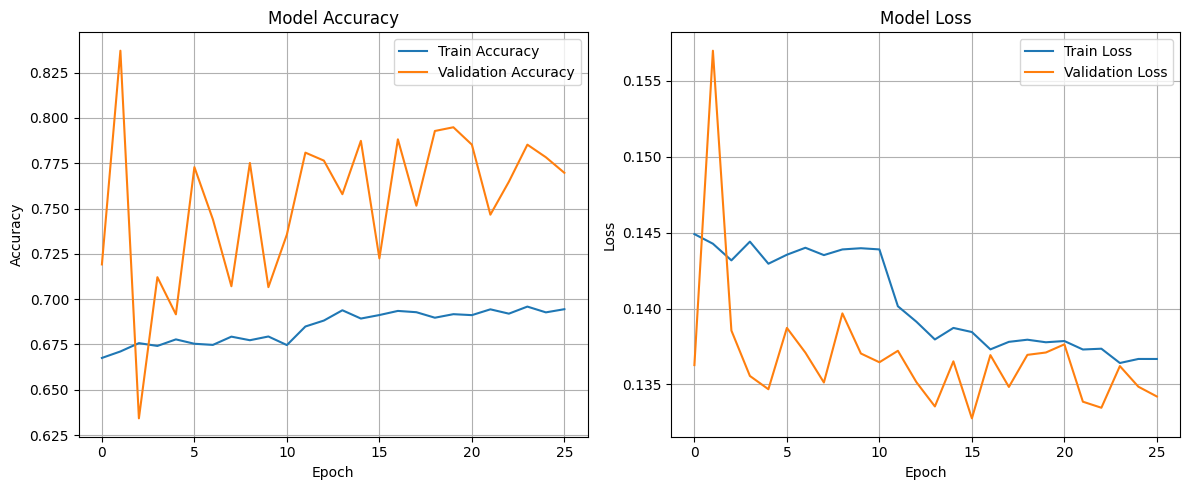


Evaluating on Validation Set (Best Model):
Final Validation Loss: 0.1328
Final Validation Accuracy: 0.7225

Confusion Matrix:
[[ 1712   708]
 [ 4842 12738]]


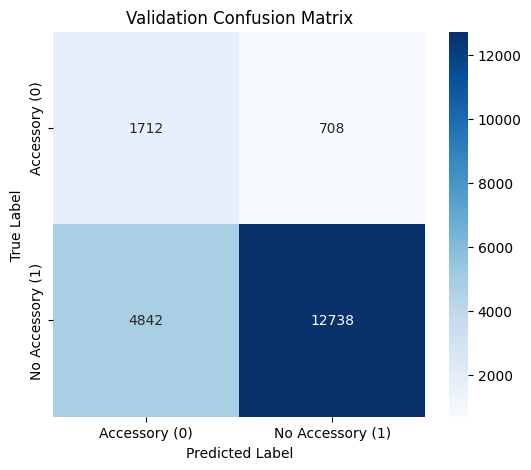


Classification Report:
                  precision    recall  f1-score   support

   Accessory (0)       0.26      0.71      0.38      2420
No Accessory (1)       0.95      0.72      0.82     17580

        accuracy                           0.72     20000
       macro avg       0.60      0.72      0.60     20000
    weighted avg       0.86      0.72      0.77     20000



In [ ]:
if history:
    plot_training_history(history)
if val_loader and model and criterion:
    print("\nEvaluating on Validation Set (Best Model):")
    val_loss, val_acc, val_preds_probs, val_true_labels = evaluate_model(model, val_loader, criterion, device)
    print(f"Final Validation Loss: {val_loss:.4f}")
    print(f"Final Validation Accuracy: {val_acc:.4f}")
    roc_auc = roc_auc_score(val_true_labels, val_preds_probs)
    val_pred_classes = (np.array(val_preds_probs) > 0.5).astype(int)
    print("\nConfusion Matrix:")
    cm = confusion_matrix(val_true_labels, val_pred_classes)
    print(cm)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Accessory (0)', 'No Accessory (1)'], yticklabels=['Accessory (0)', 'No Accessory (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Validation Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(val_true_labels, val_pred_classes, target_names=['Accessory (0)', 'No Accessory (1)']))

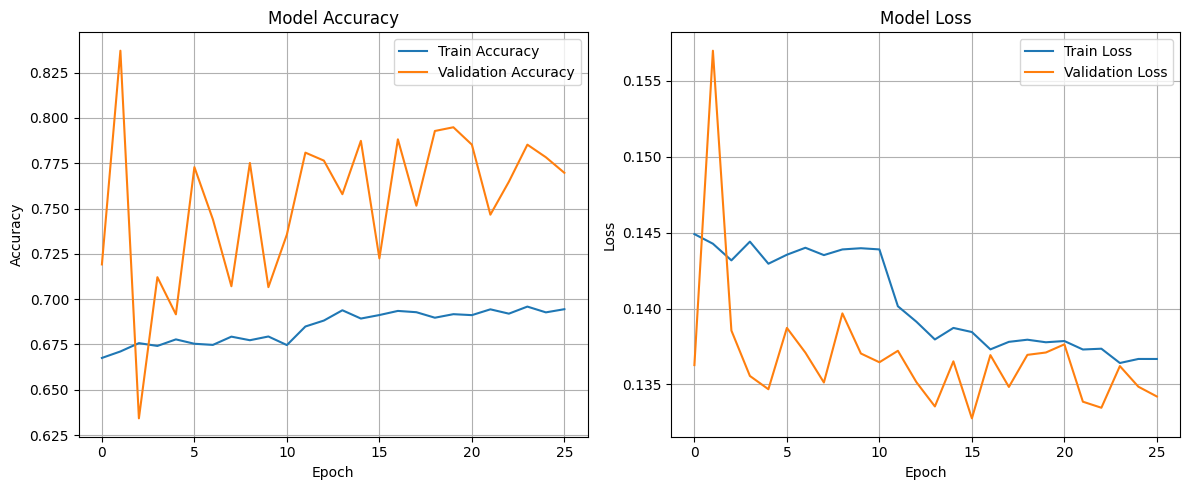


Evaluating on Validation Set (Best Model):
Final Validation Loss: 0.1328
Final Validation Accuracy: 0.7225
Validation ROC AUC: 0.7948

Confusion Matrix:
[[ 1712   708]
 [ 4842 12738]]


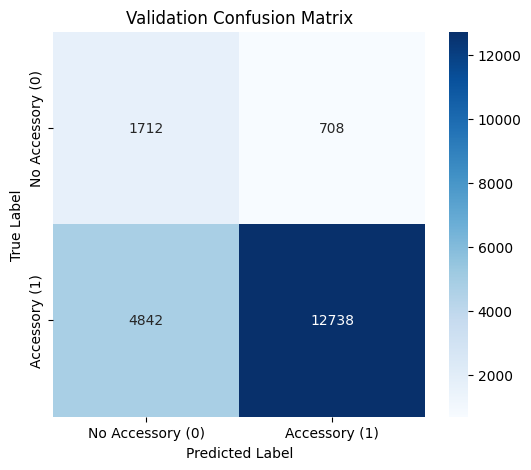


Classification Report:
                  precision    recall  f1-score   support

No Accessory (0)       0.26      0.71      0.38      2420
   Accessory (1)       0.95      0.72      0.82     17580

        accuracy                           0.72     20000
       macro avg       0.60      0.72      0.60     20000
    weighted avg       0.86      0.72      0.77     20000



In [ ]:
if history:
    plot_training_history(history)
if val_loader and model and criterion:
    # Final evaluation on validation set with the best model (already loaded by train_model)
    print("\nEvaluating on Validation Set (Best Model):")
    val_loss, val_acc, val_preds_probs, val_true_labels = evaluate_model(model, val_loader, criterion, device)
    print(f"Final Validation Loss: {val_loss:.4f}")
    print(f"Final Validation Accuracy: {val_acc:.4f}")

    # Calculate ROC AUC if enough samples and both classes are present
    if len(set(val_true_labels)) == 2 and len(val_true_labels) > 1:
        try:
            roc_auc = roc_auc_score(val_true_labels, val_preds_probs)
            print(f"Validation ROC AUC: {roc_auc:.4f}")
        except ValueError as e:
            print(f"Could not calculate ROC AUC: {e}") # e.g. only one class present in y_true

    # Confusion Matrix and Classification Report
    val_pred_classes = (np.array(val_preds_probs) > 0.5).astype(int)
    print("\nConfusion Matrix:")
    cm = confusion_matrix(val_true_labels, val_pred_classes)
    print(cm)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Accessory (0)', 'Accessory (1)'], yticklabels=['No Accessory (0)', 'Accessory (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Validation Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(val_true_labels, val_pred_classes, target_names=['No Accessory (0)', 'Accessory (1)']))

# 10.  Load trained pytorch model (optional)

In [28]:
# MODEL_SAVE_PATH = "/content/drive/MyDrive/Deep/thera/Mobile_Net_V2.pth"
# MODEL_SAVE_PATH = "Mobile_Net_V2.pth"
# MODEL_SAVE_PATH = "Mobile_Net_full_finetuning.pth"
MODEL_SAVE_PATH = "Mobile_Net_full_finetuning_weighted_loss.pth"
# MODEL_SAVE_PATH = "Mobile_Net_partial_finetuning_weighted_loss.pth"

## A. Pytorch Model

In [ ]:
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Loading model from saved path: {MODEL_SAVE_PATH}")
    try:
        model = SimpleCNN(img_width=IMG_WIDTH, img_height=IMG_HEIGHT, num_classes=NUM_CLASSES).to(device)
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading saved model: {e}")
        model = None
else:
    print("No trained model available from current session or saved path.")


Loading model from saved path: /content/drive/MyDrive/Deep/thera/Balenced_Simple_CCN_40_epochs.pth
Model loaded successfully.


## B. MobileNetV2

In [29]:
import torchvision.models as models

model = None
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Loading MobileNetV2 model from: {MODEL_SAVE_PATH}")
    try:
        model = models.mobilenet_v2(weights=None) # Load architecture, no pre-trained weights here
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(num_ftrs, 1)
        )

        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        model = model.to(device)
    except Exception as e:
        print(f"Error loading MobileNetV2 model: {e}")
else:
    print("No trained model available from saved path.")


Loading MobileNetV2 model from: Mobile_Net_full_finetuning_weighted_loss.pth


# 11. Calculate HTER

In [30]:
val_pred_classes_list = []
val_true_labels_from_loader = []

if 'model' in locals() and model is not None and \
   'val_loader' in locals() and val_loader is not None and \
   'device' in locals():

    model.eval()

    with torch.no_grad(): # Disable gradient calculations for inference
        for inputs, labels_batch in val_loader:
            inputs = inputs.to(device)

            outputs = model(inputs)
            predicted_probs = torch.sigmoid(outputs)
            batch_pred_classes = (predicted_probs > 0.5).cpu().numpy().astype(int)

            val_pred_classes_list.extend(batch_pred_classes.flatten())
            val_true_labels_from_loader.extend(labels_batch.cpu().numpy().astype(int).flatten())

    if len(val_true_labels_from_loader) > 0 and len(val_pred_classes_list) == len(val_true_labels_from_loader):
        val_true_labels_np = np.array(val_true_labels_from_loader)
        val_pred_classes_np = np.array(val_pred_classes_list)

        # For class 0
        tn = np.sum((val_true_labels_np == 0) & (val_pred_classes_np == 0))
        fp = np.sum((val_true_labels_np == 0) & (val_pred_classes_np == 1))
        recall_class_0_tnr = tn / (tn + fp) if (tn + fp) > 0 else 0 # Specificity / TNR

        # For Class 1
        tp = np.sum((val_true_labels_np == 1) & (val_pred_classes_np == 1))
        fn = np.sum((val_true_labels_np == 1) & (val_pred_classes_np == 0))
        recall_class_1_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 # Sensitivity / TPR

        # HTER = (FPR_for_class0 + FNR_for_class1) / 2
        fpr_class0 = 1 - recall_class_0_tnr
        fnr_class1 = 1 - recall_class_1_tpr
        hter = (fpr_class0 + fnr_class1) / 2.0

        print(f"Recall Class 0 : {recall_class_0_tnr:.4f}")
        print(f"Recall Class 1 : {recall_class_1_tpr:.4f}")
        print(f"Calculated HTER: {hter:.4f}")
    else:
        print("Prediction or label collection failed, or lengths mismatched.")

Recall Class 0 : 0.9207
Recall Class 1 : 0.9094
Calculated HTER: 0.0850


# 12. Predict on Val

In [31]:
# Define path for the output prediction file
OUTPUT_PREDICTION_FILE_VAL = os.path.join(TARGET_WORKING_DIR, 'label_val.txt') # Save in the local data root



if model and os.path.exists(LOCAL_VAL_IMAGE_DIR) and os.listdir(LOCAL_VAL_IMAGE_DIR):
    if 'data_transforms' in locals() and 'val' in data_transforms:
        prediction_transform = data_transforms['val']

        # Get a sorted list of image files from the validation directory
        val_image_filenames = sorted([
            f for f in os.listdir(LOCAL_VAL_IMAGE_DIR)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])

        if not val_image_filenames:
            print(f"No image files found in {LOCAL_VAL_IMAGE_DIR}.")
        else:
            print(f"Found {len(val_image_filenames)} images in {LOCAL_VAL_IMAGE_DIR} for prediction.")

            all_predictions_val = []
            model.eval() # evaluation mode
            model = model.to(device)

            for img_name in tqdm.tqdm(val_image_filenames, desc="Predicting on val_img"):
                img_path = os.path.join(LOCAL_VAL_IMAGE_DIR, img_name)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img_tensor = prediction_transform(img).unsqueeze(0).to(device)

                    with torch.no_grad():
                        output_logit = model(img_tensor)
                        prediction_proba = torch.sigmoid(output_logit).item()

                    pred_class = 1 if prediction_proba > 0.5 else 0
                    all_predictions_val.append(pred_class)
                except Exception as e:
                    print(f"Error pred for image {img_name}: {e} -1 as placeholder.")
                    all_predictions_val.append(-1)

            # saving predictions to label_val.txt
            try:
                with open(OUTPUT_PREDICTION_FILE_VAL, 'w') as f:
                    for pred in all_predictions_val:
                        f.write(f"{pred}\n")
                print(f"\nPredictions saved to: {OUTPUT_PREDICTION_FILE_VAL}")
                print(f"Total predictions made: {len(all_predictions_val)}")
                print(f"Prediction distribution:\n{pd.Series(all_predictions_val).value_counts()}")

            except Exception as e:
                print(f"Error writing predictions to file: {e}")
    else:
        print("Validation data transforms ('data_transforms['val']') not found. Cannot preprocess images for prediction.")
elif not model:
    print("Model not available for prediction.")
else:
    print(f"Validation image directory {LOCAL_VAL_IMAGE_DIR} is empty or does not exist.")

print("--- Prediction on Validation Images Finished ---")

Found 20000 images in /content/face_classification_data/val_img for prediction.


Predicting on val_img: 100%|██████████| 20000/20000 [02:19<00:00, 143.23it/s]


Predictions saved to: /content/drive/MyDrive/Deep/thera/label_val.txt
Total predictions made: 20000
Prediction distribution:
1    16421
0     3579
Name: count, dtype: int64
--- Prediction on Validation Images Finished ---
